# Dataset: **Civil Comments**

## Dataset Description

The **Civil Comments** dataset contains over 1.9 million public comments posted between 2015 and 2017 on the Civil Comments platform. After the platform closured, the data was annotated for toxicity-related attributes by a Google subsidiary, and split into train, test, and validation sets.

### Key Features:
- **text** (*string*): The original comment text.  
- **toxicity**, **severe_toxicity**, **obscene**, **threat**, **insult**, **identity_attack**, **sexual_explicit** (*float32*): Annotated toxicity scores (*not used in this study*).

As this is an **unsupervised learning** task, we focus exclusively on the comment text to uncover latent patterns in language and discourse.


## Project Objective

The main goal is to explore the **underlying structure** of online comments without using toxicity labels.  
We aim to group similar comments using **clustering algorithms** to discover distinct themes or topics in online discussion  

## Why ?

Understanding these patterns provides valuable insights for:

- **Moderation systems**: Identifying and acting on toxic or problematic topic patterns at a group level  
- **Social researchers**: Analyzing how and on what people communicate in online forums  
- **Platform design**: Informing better user experience and comment filtering

Uncovering natural clusters — without relying on predefined labels — opens the door to more flexible and adaptive tools for online communication analysis. The main challenge in this task is that online comment language is often informal, ambiguous, or sarcastic, which makes unsupervised structure discovery non-trivial.


In [3]:
#ismports

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
import seaborn as sns


# required NLTK data (run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

2025-07-08 16:42:45.754258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 16:42:46.223080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751985766.408666    1417 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751985766.466381    1417 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751985766.874498    1417 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Import dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("google/civil_comments")

# Data Cleaning Pipeline

To ensure good quality input for text clustering, we apply a rigorous preprocessing pipeline. Text clustering algorithms like KMeans or DBSCAN are highly sensitive to noisy, irrelevant, or inconsistent input — hence, preprocessing is essential. Also, since we decide to pick a base of only 10000 comments to not spend too long on training, we need to be extra vigourous in avoiding the noise.

## Why Preprocessing Matters

Short or trivial comments don't carry enough semantic information and can distort cluster formation so we set limits on how small or big a comment can be. We also remove URLs, email addresses, HTML tags, and special characters to avoid noise. Words like "the", "and", etc.. don't carry a lot of meaning and occur in almost every sentence so we remove them. We also noticed that some custom stopwords would imbalence the clustering too much when testing so we remove them. Finally, we also reduces words to their base form (lemmatization) to help groupe semantically similar tokens. 

## Cleaning Pipeline Steps

The pipeline is implemented in the following steps:

1. **Basic Cleaning**:  
   - Lowercasing  
   - Removing URLs, emails, HTML tags  
   - Removing non-alphabetical characters  
   - Expanding contractions (e.g., *won’t* → *will not*)
2. **Length Filtering**:  
   We retain only comments that:
   - Are between **100 and 1000 characters**  
   - Contain at least **10 words**
3. **Stopword Removal and Lemmatization**:  
   - Apply NLTK’s stopwords  
   - Add a domain-specific stopword list  
   - Tokenize and lemmatize using `WordNetLemmatizer`

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

def basic_clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\t\r]', ' ', text)
    text = re.sub(r"[^a-z\s']", '', text)
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
        "'m": " am", "'s": " is"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    text = re.sub(r"'", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def filter_by_length(texts, min_length=100, max_length=1000,  min_words=10):
    """Filter texts by character length"""
    return [text for text in texts if min_length <= len(text) <= max_length and len(text.split()) >= min_words]
    
def remove_stopwords_and_lemmatize(texts):
    """Remove stopwords and lemmatize using NLTK"""
    stop_words = set(stopwords.words('english'))
    custom_stopwords = set([
        "would", "like", "one", "people", "get", "think", "know", "time", "comment",
        "year", "want", "make", "really", "good", "great", "thing", "lot", "well",
        "say", "even", "also", "still", "much", "many", "see", "something",
        "article", "post", "posted", "posting", "response", "issue", "statement", "opinion", "fact",
        "work", "sure", "point", "thank", "thanks", "cool", "love",
        "person", "member", "someone", "anyone", "way", "right", "civil", "need", "read", "story", "life", "day", "mean", "new", "could", "take", "going"
    ])
    stop_words = stop_words.union(custom_stopwords)
    
    lemmatizer = WordNetLemmatizer()
    
    processed_texts = []
    
    for text in texts:
        tokens = word_tokenize(text)
        filtered_tokens = [
            lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in stop_words and len(token) > 2
        ]
        processed_texts.append(' '.join(filtered_tokens))
    
    return processed_texts

def clean_comments_pipeline(comments, min_length=50, max_length=1000, min_word_freq=3, min_words=5, verbose=True):
    print(f"Starting with {len(comments)} comments")
    
    cleaned = [basic_clean_text(comment) for comment in comments]
    cleaned = [c for c in cleaned if c]  # Remove empty strings
    print(f"After basic cleaning: {len(cleaned)} comments")
    
    length_filtered = filter_by_length(cleaned, min_length, max_length)
    print(f"After length filtering ({min_length}-{max_length} chars): {len(length_filtered)} comments")
    
    final_comments = remove_stopwords_and_lemmatize(length_filtered)
    print(f"Final dataset: {len(final_comments)} comments")
    
    return final_comments

def get_cleaning_stats(original_comments, cleaned_comments):
    stats = {
        'original_count': len(original_comments),
        'final_count': len(cleaned_comments),
        'retention_rate': len(cleaned_comments) / len(original_comments) * 100,
        'avg_length_original': sum(len(c) for c in original_comments) / len(original_comments),
        'avg_length_cleaned': sum(len(c) for c in cleaned_comments) / len(cleaned_comments),
        'avg_words_cleaned': sum(len(c.split()) for c in cleaned_comments) / len(cleaned_comments)
    }
    return stats

comments = ds["train"]["text"][:10000]

cleaned_comments = clean_comments_pipeline(comments)

stats = get_cleaning_stats(comments, cleaned_comments)
print("\nCleaning Statistics:")
for key, value in stats.items():
     print(f"{key}: {value:.2f}")

print("\nExample cleaned comments:")
for i, comment in enumerate(cleaned_comments[:3]):
    print(f"\nComment {i+1}:")
    print(comment[:200] + "..." if len(comment) > 200 else comment)

Starting with 10000 comments
After basic cleaning: 9989 comments
After length filtering (50-1000 chars): 8948 comments
Final dataset: 8948 comments

Cleaning Statistics:
original_count: 10000.00
final_count: 8948.00
retention_rate: 89.48
avg_length_original: 353.72
avg_length_cleaned: 217.31
avg_words_cleaned: 29.57

Example cleaned comments:

Comment 1:
mother idea done

Comment 2:
less anxietyinducing keep let

Comment 3:
urgent design problem kudos taking impressive


# Data Preproessing

## Vectorization with TF-IDF

TF-IDF (Term Frequency–Inverse Document Frequency) transforms each comment into a sparse vector, where each dimension corresponds to a word. The value is higher for words that are important in a specific comment but rare in the overall corpus.

We will use TF-IDF as a baseline method for text representation.


In [6]:
def create_tfidf_vectors(texts, max_features=5000, min_df=2, max_df=0.8):
    print(f"Creating TF-IDF vectors with max_features={max_features}")
    
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 2),
        stop_words=None #already done
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    return tfidf_matrix, vectorizer, feature_names

def get_tfidf_stats(tfidf_matrix, feature_names, top_n=10):
    mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    top_indices = mean_scores.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]
    
    stats = {
        'matrix_shape': tfidf_matrix.shape,
        'sparsity': 1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])),
        'top_features': top_features
    }
    
    return stats

def print_tfidf_stats(stats):
    print(f"TF-IDF matrix shape: {stats['matrix_shape']}")
    print(f"Sparsity: {stats['sparsity']:.4f}")
    print("Top features:")
    for word, score in stats['top_features']:
        print(f"{word}: {score:.4f}")


tfidf_matrix, vectorizer, tfidf_features = create_tfidf_vectors(cleaned_comments)
tfidf_stats = get_tfidf_stats(tfidf_matrix, tfidf_features)
print_tfidf_stats(tfidf_stats)

Creating TF-IDF vectors with max_features=5000
TF-IDF matrix shape: (8948, 5000)
Number of features: 5000
TF-IDF matrix shape: (8948, 5000)
Sparsity: 0.9955
Top features:
oregon: 0.0097
state: 0.0096
money: 0.0089
year: 0.0087
city: 0.0086
school: 0.0079
public: 0.0079
tax: 0.0077
portland: 0.0077
trump: 0.0076


## BERT Embeddings

To go beyond the limitations of TF-IDF, we will use BERT-based sentence embeddings (with Sentence Transformers) to capture the semantic meaning of comments, including context and word relationships.

This allows clustering methods to better identify comment types and topics, even when they use different wording.


In [11]:
# we use miniLM as it is fast and effective
def bert_embedding(comments, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(comments, show_progress_bar=True)
    return embeddings
    
bert_embeddings = bert_embedding(cleaned_comments)


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

# Dimensionality Reduction

High-dimensional data (like TF-IDF vectors or BERT embeddings) can harm clustering performance due to the "curse of dimensionality". This is when the efficiency and effectiveness of algorithms deteriorate as the dimensionality of the data increases.
Dimensionality reduction techniques help compress data into a smaller, denser representation that preserves meaningful structure while reducing noise.

We use:
- **TruncatedSVD** for TF-IDF vectors (sparse input)
- **PCA** or **UMAP** for dense BERT embeddings

We will also scale the data at this step. TruncatedSVD is designed for sparse data and performs a form of scaling internally so no need to add an extra one on top. And for PCA and UMAP, Standardizing can help some clustering methods.  
This step improves clustering quality, execution speed and visualization


In [12]:
from sklearn.decomposition import TruncatedSVD, PCA
import umap.umap_ as umap

def reduce_tfidf(tfidf_matrix, n_components=100):
    print(f"Reducing TF-IDF with TruncatedSVD to {n_components} dimensions")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    return svd.fit_transform(tfidf_matrix)

def reduce_bert_pca(embeddings, n_components=50):
    print(f"Reducing BERT embeddings with PCA to {n_components} dimensions")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(embeddings)

def reduce_bert_umap(embeddings, n_components=50, n_neighbors=15, min_dist=0.1):
    print(f"Reducing BERT embeddings with UMAP to {n_components} dimensions")
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric='cosine', random_state=42)
    return reducer.fit_transform(embeddings)

# TF-IDF reduction
reduced_tfidf = reduce_tfidf(tfidf_matrix, n_components=100)

# BERT reduction
reduced_bert = reduce_bert_pca(bert_embeddings, n_components=50)
reduced_bert_umap = reduce_bert_umap(bert_embeddings)

from sklearn.preprocessing import StandardScaler
reduced_bert = StandardScaler().fit_transform(reduced_bert)




Reducing TF-IDF with TruncatedSVD to 100 dimensions
Reducing BERT embeddings with PCA to 50 dimensions
Reducing BERT embeddings with UMAP to 50 dimensions


/home/eugenie/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Clustering methods

## KMeans

We use the KMeans algorithm to group comments into clusters based on their content similarity. This is an unsupervised method that tries to partition the data into `k` clusters such that each comment belongs to the cluster with the nearest centroid.

We apply KMeans on two types of embeddings:

- **TF-IDF vectors**: sparse, high-dimensional, based on word frequency.
- **BERT embeddings**: dense, semantic vectors capturing meaning of full sentences.

In [28]:
def perform_kmeans_clustering(X, k_range=(3, 10), metric_name="TF-IDF"):
    best_score = -1
    best_k = None
    best_model = None
    scores = []
    
    print(f"Running KMeans on {metric_name} vectors...")
    
    for k in range(k_range[0], k_range[1]+1):
        model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            scores.append((k, score))
            print(f"k={k}, silhouette score={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_k = k
                best_model = model
    
    print(f"\nBest K: {best_k}, Best silhouette score: {best_score:.4f}")
    return best_model, best_k, best_score, scores

# TF-IDF
#kmeans_tfidf, k_tfidf, score_tfidf = perform_kmeans_clustering(tfidf_matrix, k_range=(3, 10), metric_name="TF-IDF")

#BERT
#kmeans_bert, k_bert, score_bert = perform_kmeans_clustering(bert_vectors, k_range=(3, 10), metric_name="BERT")

#same but reduced dimensions
#kmeans_tfidf, k_tfidf, score_tfidf = perform_kmeans_clustering(reduced_tfidf, k_range=(3, 10), metric_name="TF-IDF")
#kmeans_bert, k_bert, score_bert = perform_kmeans_clustering(reduced_bert, k_range=(3, 10), metric_name="BERT (PCA)")
#kmeans_umap, k_umap, score_umap = perform_kmeans_clustering(reduced_bert_umap, k_range=(3, 10), metric_name="BERT (UMAP)")



# Evaluation

## Metric 
To evaluate our K-means we have done the choice to use the silhouette score. This metric is commonly used because it evaluates how well each data point fits within its assigned cluster, and how distinctly separated it is from other clusters. Ce score est entre [-1; 1]

Formula: 
- Le score silhouette $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$ avec
-  *a(i)* = distance moyenne aux points de son cluster  
- *b(i)* = distance moyenne au cluster le plus proche

Reading the silhouette score: 
- Close to +1 means the data point fits in its own cluster and is far from others.
- Close to 0 means the data point is between clusters / clusters are overlapping.
- Close to -1 means the data point is in the wrong cluster.

In [30]:
def visualize_clusters(vectors, cluster_labels, title, sample_size=1000):
    vectors_dense = vectors
    vectors_sample = vectors_dense
    labels_sample = cluster_labels
    
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors_sample)
    
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels_sample)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:  # Noise points (DBSCAN)
            plt.scatter(vectors_2d[labels_sample == label, 0], 
                       vectors_2d[labels_sample == label, 1], 
                       c='black', marker='x', s=50, alpha=0.5, label='Noise')
        else:
            plt.scatter(vectors_2d[labels_sample == label, 0], 
                       vectors_2d[labels_sample == label, 1], 
                       c=[color], s=50, alpha=0.7, label=f'Cluster {label}')
    
    plt.title(f'{title}\nPCA Visualization (explained variance: {pca.explained_variance_ratio_.sum():.2%})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.show()
    
    return pca

def plot_silhouette_scores(scores_dict):
    plt.figure(figsize=(12, 6))
    
    for method_name, scores in scores_dict.items():
        k_values = [score[0] for score in scores]
        silhouette_values = [score[1] for score in scores]
        plt.plot(k_values, silhouette_values, marker='o', label=method_name)
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def comprehensive_clustering_analysis(vectors_dict, texts, vectorizer=None, k_range=(3, 10)):
    results = {}
    all_scores = {}

    print("=" * 6, " Starting Comprehensive Clustering Analysis", "=" * 6)
    
    for vector_name, vectors in vectors_dict.items():
        print(f"\nProcessing {vector_name}...")
        model, k, score, scores = perform_kmeans_clustering(vectors, k_range, vector_name)
        results[vector_name] = (model, k, score, scores)
        all_scores[vector_name] = scores

    plot_silhouette_scores(all_scores)

    print("\nGenerating Visualizations...")
    print("-" * 30)

    for vector_name, (model, k, score, scores) in results.items():
        vectors = vectors_dict[vector_name]
        labels = model.labels_
        pca = visualize_clusters(vectors, labels, f"{vector_name} Clustering (k={k})")
        print(f"\nAnalyzing content of {vector_name} clusters:")
        unique_labels = np.unique(labels)

        for label in unique_labels:                
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            all_words = " ".join(cluster_texts).lower().split()
            word_counts = Counter(all_words)
            top_words = word_counts.most_common(10)
            print(f"\nCluster {label} ({len(cluster_texts)} texts):")
            print("Top words:")
            for word, count in top_words:
                print(f"  {word}: {count}")
    plt.show()
    return results

In [29]:

vectors_dict = {
    'TF-IDF': tfidf_matrix,
    'BERT': bert_vectors,
    'TF-IDF (Reduced)': reduced_tfidf,
    'BERT (PCA)': reduced_bert,
    'BERT (UMAP)': reduced_bert_umap
}

#results = comprehensive_clustering_analysis(
#    vectors_dict=vectors_dict,
#    texts=cleaned_comments,
#    vectorizer=vectorizer,
#    k_range=(3, 10)
#)

# Comparaison between Kmeans with Tf-idf reduced vs non reduced

======  Starting Comprehensive Clustering Analysis ======

Processing TF-IDF...
Running KMeans on TF-IDF vectors...
k=3, silhouette score=0.0011
k=4, silhouette score=0.0019
k=5, silhouette score=0.0025
k=6, silhouette score=0.0028
k=7, silhouette score=0.0033
k=8, silhouette score=0.0035
k=9, silhouette score=0.0038
k=10, silhouette score=0.0039

Best K: 10, Best silhouette score: 0.0039

Processing TF-IDF (Reduced)...
Running KMeans on TF-IDF (Reduced) vectors...
k=3, silhouette score=0.0695
k=4, silhouette score=0.0706
k=5, silhouette score=0.0698
k=6, silhouette score=0.0725
k=7, silhouette score=0.0761
k=8, silhouette score=0.0743
k=9, silhouette score=0.0767
k=10, silhouette score=0.0790

Best K: 10, Best silhouette score: 0.0790


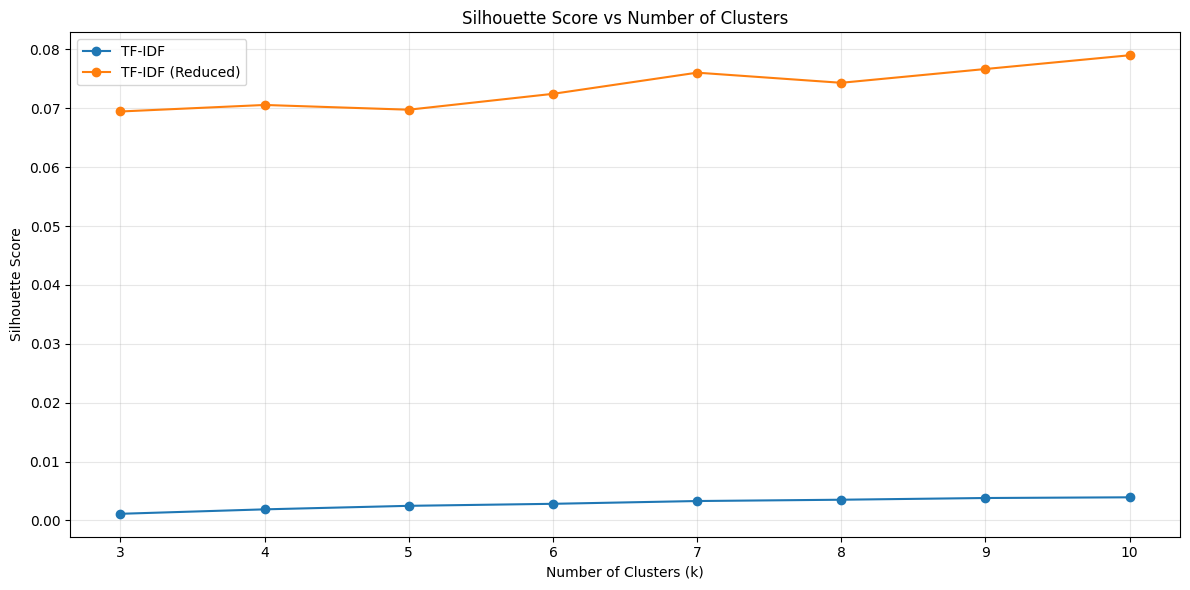


Generating Visualizations...
------------------------------

Analyzing content of TF-IDF clusters:

Cluster 0 (127 texts):
Top words:
  sound: 136
  trying: 9
  maybe: 9
  heard: 8
  little: 8
  year: 8
  hit: 8
  ever: 8
  case: 8
  public: 8

Cluster 1 (323 texts):
Top words:
  school: 554
  student: 326
  parent: 125
  kid: 121
  high: 121
  education: 111
  child: 107
  teacher: 95
  class: 82
  college: 74

Cluster 2 (727 texts):
Top words:
  state: 442
  law: 429
  government: 291
  oregon: 259
  federal: 184
  public: 171
  land: 167
  gun: 149
  court: 133
  police: 120

Cluster 3 (580 texts):
Top words:
  city: 565
  homeless: 270
  eugene: 248
  housing: 217
  portland: 141
  public: 130
  downtown: 87
  place: 84
  park: 84
  problem: 80

Cluster 4 (148 texts):
Top words:
  wage: 354
  minimum: 229
  job: 94
  pay: 85
  increase: 82
  worker: 65
  oregon: 56
  cost: 56
  business: 52
  hour: 52

Cluster 5 (424 texts):
Top words:
  tax: 538
  money: 310
  pay: 176
  oregon: 

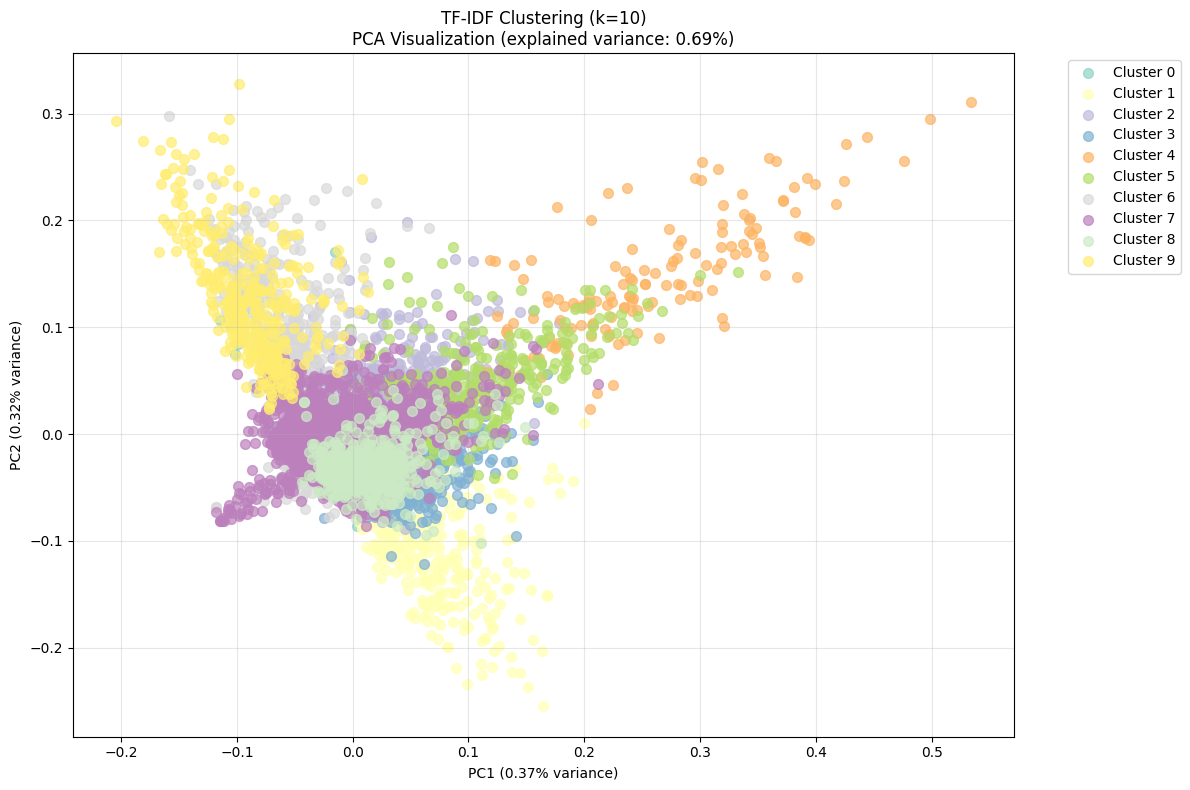

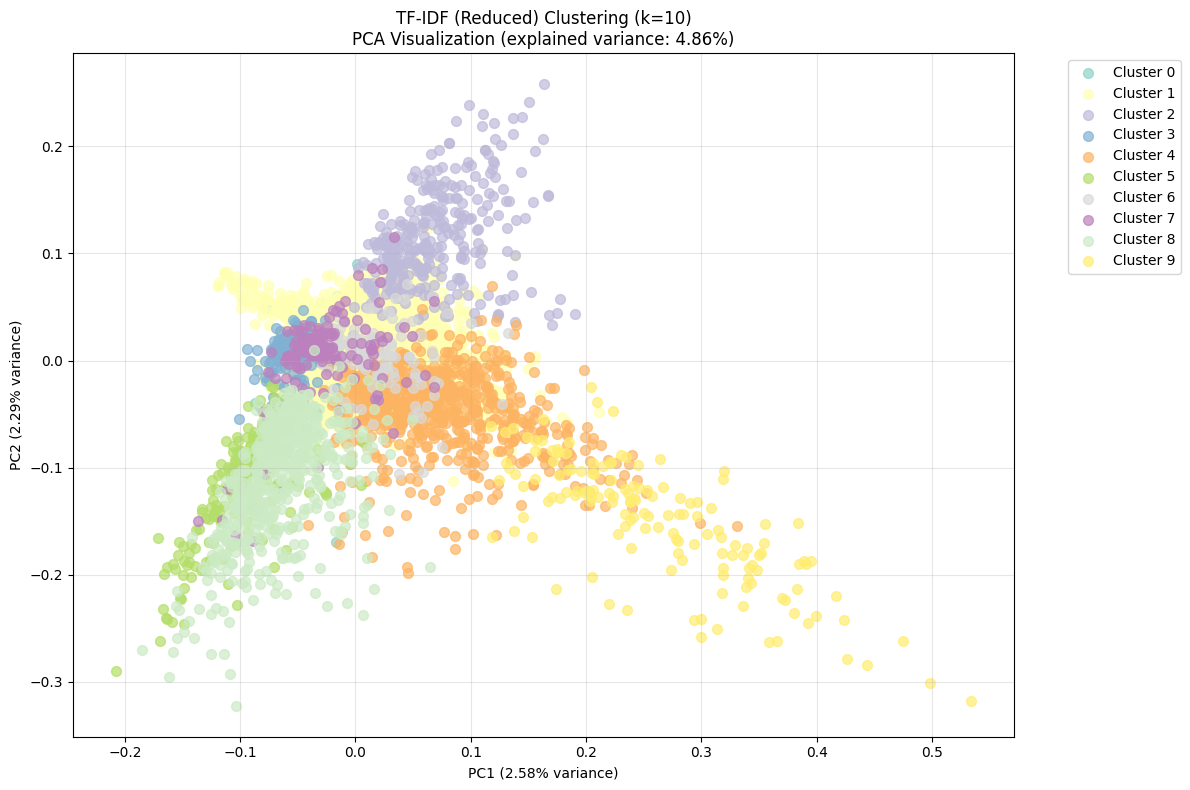

In [27]:

vectors_dict = {
    'TF-IDF': tfidf_matrix,
    'TF-IDF (Reduced)': reduced_tfidf,
}

results = comprehensive_clustering_analysis(
    vectors_dict=vectors_dict,
    texts=cleaned_comments,
    vectorizer=vectorizer,
    k_range=(3, 10)
)

## FIXME : add analysis

# Analysis between Kmeans with BERT reduced with PCA, reduced with UMAP vs non reduced

======  Starting Comprehensive Clustering Analysis ======

Processing BERT...
Running KMeans on BERT vectors...
k=3, silhouette score=0.0220
k=4, silhouette score=0.0205
k=5, silhouette score=0.0198
k=6, silhouette score=0.0203
k=7, silhouette score=0.0206
k=8, silhouette score=0.0195
k=9, silhouette score=0.0212
k=10, silhouette score=0.0199

Best K: 3, Best silhouette score: 0.0220

Processing BERT (PCA)...
Running KMeans on BERT (PCA) vectors...
k=3, silhouette score=0.0159
k=4, silhouette score=0.0161
k=5, silhouette score=0.0180
k=6, silhouette score=0.0215
k=7, silhouette score=0.0239
k=8, silhouette score=0.0278
k=9, silhouette score=0.0308
k=10, silhouette score=0.0320

Best K: 10, Best silhouette score: 0.0320

Processing BERT (UMAP)...
Running KMeans on BERT (UMAP) vectors...
k=3, silhouette score=0.2641
k=4, silhouette score=0.3033
k=5, silhouette score=0.2783
k=6, silhouette score=0.3117
k=7, silhouette score=0.3210
k=8, silhouette score=0.3280
k=9, silhouette score=0.3298


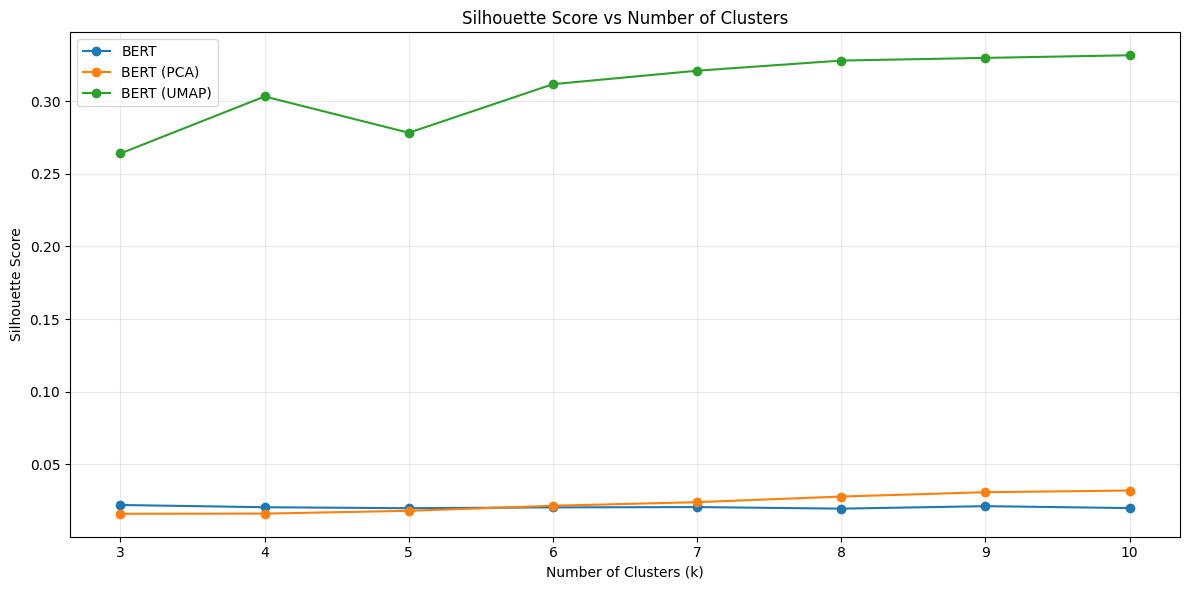


Generating Visualizations...
------------------------------

Analyzing content of BERT clusters:

Cluster 0 (3002 texts):
Top words:
  year: 160
  back: 146
  comment: 134
  show: 133
  never: 116
  got: 114
  star: 113
  portland: 111
  first: 110
  guy: 107

Cluster 1 (3191 texts):
Top words:
  trump: 470
  state: 348
  law: 329
  vote: 324
  president: 320
  republican: 319
  party: 283
  support: 275
  government: 275
  public: 262

Cluster 2 (2755 texts):
Top words:
  city: 592
  tax: 566
  money: 525
  oregon: 510
  school: 444
  state: 437
  public: 421
  pay: 416
  wage: 400
  job: 396

Analyzing content of BERT (PCA) clusters:

Cluster 0 (1260 texts):
Top words:
  star: 115
  show: 92
  war: 91
  year: 86
  back: 70
  money: 69
  never: 66
  family: 63
  guy: 63
  hope: 61

Cluster 1 (357 texts):
Top words:
  church: 244
  imago: 114
  dei: 88
  belief: 81
  christian: 71
  gay: 71
  baptist: 71
  woman: 66
  believe: 64
  conservative: 63

Cluster 2 (1078 texts):
Top words:


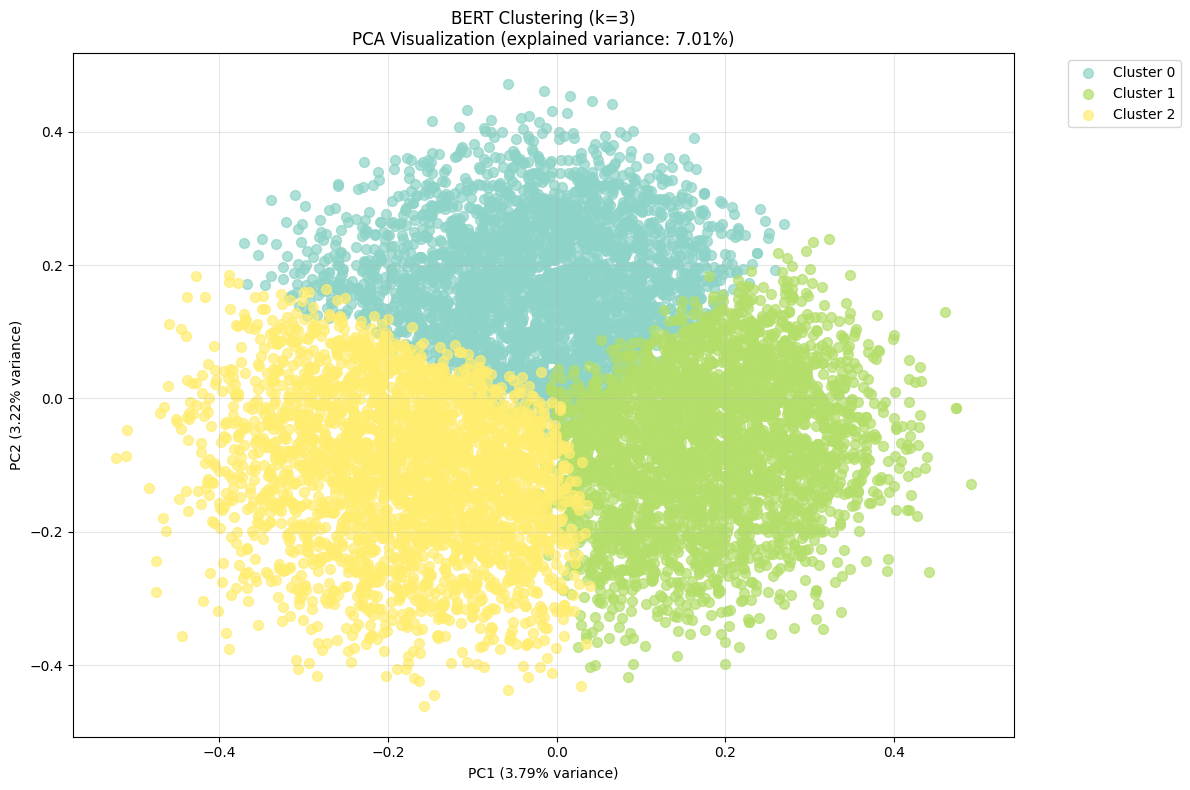

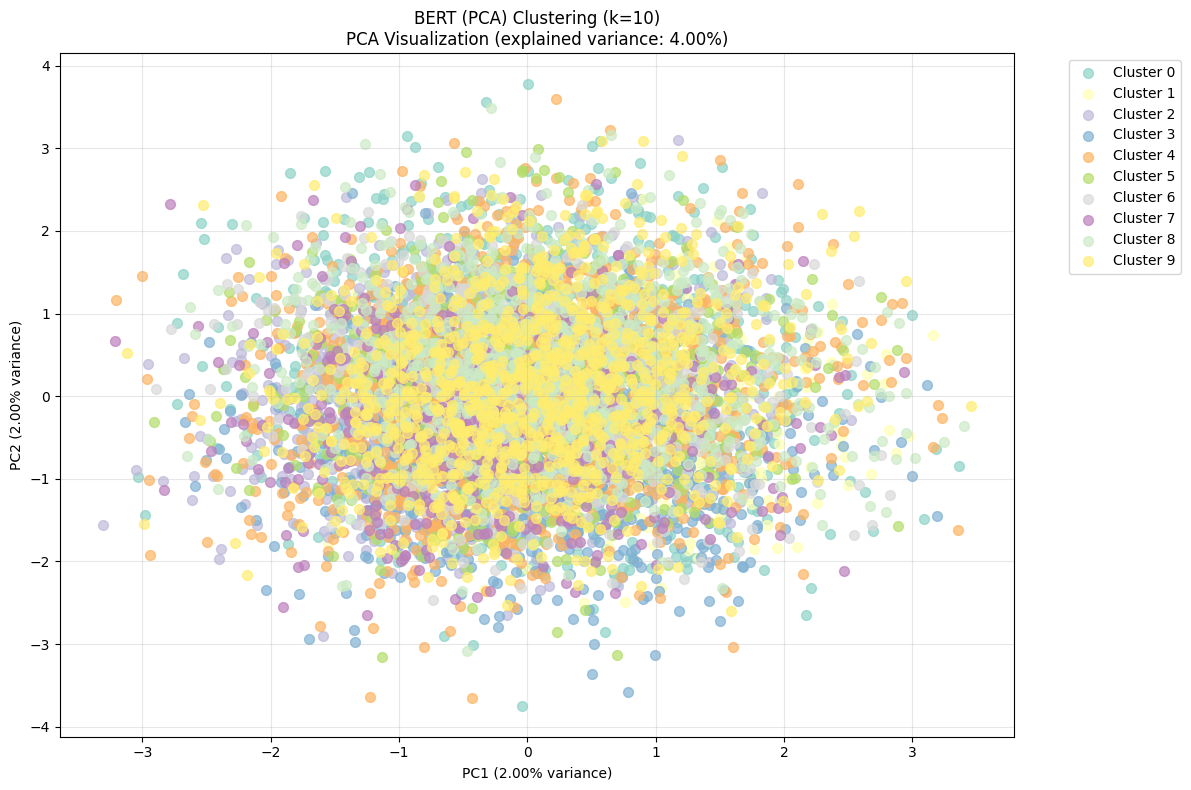

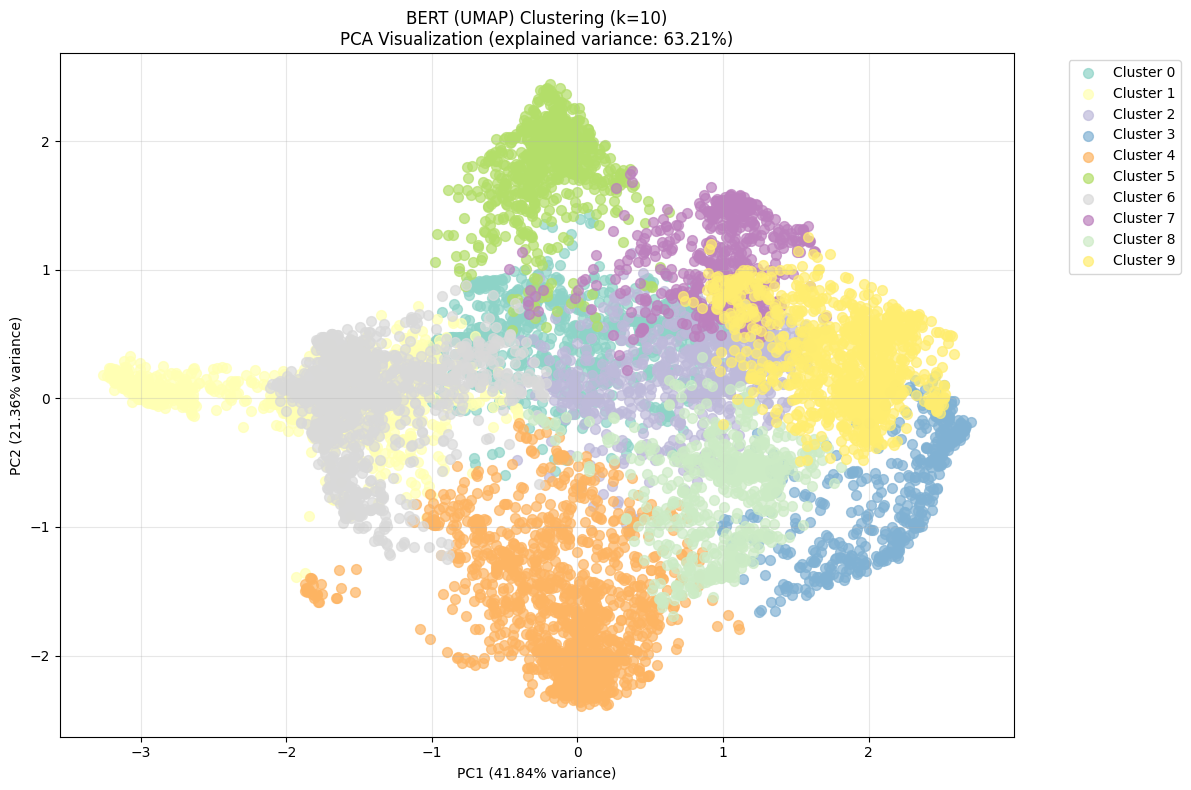

In [32]:

vectors_dict = {
    'BERT': bert_vectors,
    'BERT (PCA)': reduced_bert,
    'BERT (UMAP)': reduced_bert_umap
}

results = comprehensive_clustering_analysis(
    vectors_dict=vectors_dict,
    texts=cleaned_comments,
    vectorizer=vectorizer,
    k_range=(3, 10)
)

# Conclusion

In this exercice we have compared BERT embedding and the tfidf vectorizer in order to try to and get different categories of comments from the dataset.
To evaluate the different models we have tested we focused on the silhouette score. We hae has to reduce dimensions *explain further* in order to improve the clustering. Overall the Kmeans algorithm using Bert with umap was much more efficient to cluster categories. We also notice that this clustering 